# Mask segmentation using Unet

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image


In [103]:
data_path = '../MSFD/1/face_crop/'
ans_path = '../MSFD/1/face_crop_segmentation/'

data_list = []
ans_list = []

for fname in os.listdir(data_path):
    data_list.append(fname) 


for fname in os.listdir(ans_path):
    ans_list.append(fname) 

print(len(data_list),len(ans_list),data_list[1],ans_list[1])

9383 9383 002267_2.jpg 002267_2.jpg


In [104]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)



In [105]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [106]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [107]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [135]:
IMG_SIZE = 72

class MaskDataset(Dataset):
    def __init__(self, image_folder, mask_folder):
        super(MaskDataset, self).__init__()
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_filenames = os.listdir(image_folder)
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_folder, self.image_filenames[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Warning: Failed to load {img_path} or {mask_path}")
            return None 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = self.transform(image)

        mask = Image.fromarray(mask)
        mask = self.transform(mask)
        mask = (mask > 0.5).float()  # Convert to binary mask

        return image, mask



In [139]:

# Load dataset
full_dataset = MaskDataset(image_folder=data_path, mask_folder=ans_path)
train_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

print(f"Train Size: {train_size}, Test Size: {test_size}")



Train Size: 1876, Test Size: 7507


In [140]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.1, inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64

        self.encoder2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32

        self.bottleneck = conv_block(64, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 32 -> 64
        self.decoder1 = conv_block(128, 64)

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 64 -> 128
        self.decoder2 = conv_block(64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)

        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        x = self.bottleneck(x)

        x = self.upconv1(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder1(x)

        x = self.upconv2(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder2(x)

        return torch.sigmoid(self.final_conv(x))


# Create model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1,

In [141]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8

model = UNet(in_channels=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



## Running the Unet model

In [142]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

def iou_score(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = torch.sum(prediction_copy * target)
    union = torch.sum(prediction_copy) + torch.sum(target) - intersection

    iou = (intersection + epsilon) / (union + epsilon)

    return iou


In [143]:
x = np.array([1, 2, 3])
y = torch.from_numpy(x)

In [ ]:
num_epochs = 10

model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    epoch_dice = 0

    # Training loop
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        if images is None or masks is None:
            continue

        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Compute IoU & Dice
        iou = iou_score(outputs, masks)
        dice = dice_coefficient(outputs, masks)
        epoch_iou += iou.item()
        epoch_dice += dice.item()

    # Reduce learning rate based on scheduler
    scheduler.step()

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, IoU: {epoch_iou/len(train_loader):.4f}, Dice: {epoch_dice/len(train_loader):.4f}")


Epoch 1/10:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1/10:  71%|███████   | 84/118 [00:57<00:35,  1.05s/it]

In [ ]:
num_epochs = 10

losses = []
dices = []
ious = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    epoch_dice = 0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Compute IoU & Dice
        iou = iou_score(outputs, masks)
        dice = dice_coefficient(outputs, masks)
        epoch_iou += iou.item()
        epoch_dice += dice.item()

    avg_loss = epoch_loss / len(train_loader)
    avg_iou = epoch_iou / len(train_loader)
    avg_dice = epoch_dice / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}")


100%|██████████| 147/147 [01:32<00:00,  1.59it/s]


Epoch 1/10, Loss: 0.7280, IoU: 0.3310, Dice: 0.4969


100%|██████████| 147/147 [05:03<00:00,  2.06s/it]


Epoch 2/10, Loss: 0.6931, IoU: 0.2438, Dice: 0.3887


100%|██████████| 147/147 [04:41<00:00,  1.91s/it]


Epoch 3/10, Loss: 0.6931, IoU: 0.1967, Dice: 0.3257


100%|██████████| 147/147 [04:25<00:00,  1.81s/it]


Epoch 4/10, Loss: 0.6931, IoU: 0.1777, Dice: 0.2976


 87%|████████▋ | 128/147 [03:57<00:35,  1.86s/it]


KeyboardInterrupt: 

In [37]:
checkpoint = {
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}
torch.save(checkpoint, "unet_checkpoint.pth")
torch.save(model.state_dict(), "unet_model.pth")

In [40]:
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (upconv): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (decoder): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (final_conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def predict_and_plot_from_loader(model, test_loader, device):
    # Get a random batch from test_loader
    images, masks = next(iter(test_loader))
    
    # Select a random index from the batch
    idx = random.randint(0, len(images) - 1)

    # Get the selected image and mask
    image = images[idx].to(device)  # Move to device
    mask = masks[idx].cpu().numpy().squeeze()  # Convert mask to numpy

    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension
        predicted_mask = output.squeeze(0).squeeze(0).cpu().numpy()
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold to binary

    # Convert tensor image to NumPy (for visualization)
    image_np = image.cpu().numpy().transpose(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)

    # Plot the image, ground truth mask, and model output
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(image_np)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    ax[2].imshow(predicted_mask, cmap="gray")
    ax[2].set_title("Model Prediction")
    ax[2].axis("off")

    plt.show()

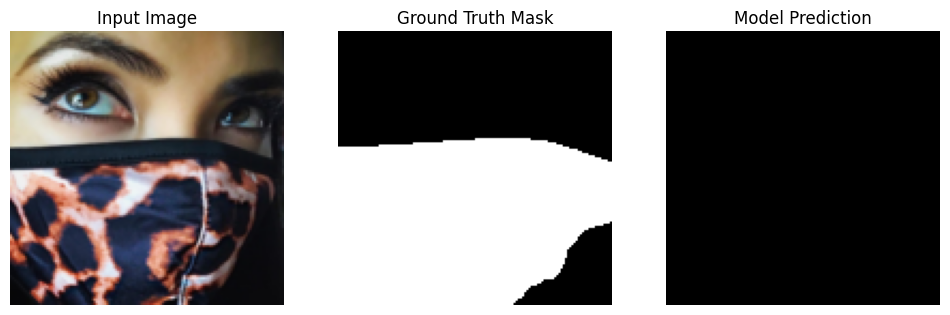

In [46]:
predict_and_plot_from_loader(model, test_loader, device)

In [ ]:
with torch.no_grad():
    output = model(image_tensor)
    predicted_mask = output.squeeze(0).squeeze(0).cpu().numpy()
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold

# Plot the image, ground truth mask, and model output
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(image)
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Ground Truth Mask")
ax[1].axis("off")

ax[2].imshow(predicted_mask, cmap="gray")
ax[2].set_title("Model Prediction")
ax[2].axis("off")

plt.show()




TypeError: 'DataLoader' object is not subscriptable

In [39]:
model.eval()
test_loss = 0
test_iou = 0
test_dice = 0

losses = []
dices = []
ious = []

with torch.no_grad():
    for images, masks in test_loader:
        try:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Compute IoU & Dice
            iou = iou_score(outputs, masks)
            dice = dice_coefficient(outputs, masks)
            test_iou += iou.item()
            test_dice += dice.item()

            losses.append(loss.item())
            dices.append(dice.item())
            ious.append(iou.item())
        except:
            pass


avg_test_loss = test_loss / len(test_loader)
avg_test_iou = test_iou / len(test_loader)
avg_test_dice = test_dice / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}, IoU: {avg_test_iou:.4f}, Dice: {avg_test_dice:.4f}")


[ WARN:0@44222.288] global loadsave.cpp:268 findDecoder imread_('../MSFD/1/face_crop_segmentation/000601_1.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [ ]:
epochs_list = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, losses, label='Training Loss')
plt.xticks(ticks=list(range(1, num_epochs + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, dices, label='Training DICE')
plt.plot(epochs_list, ious, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()